In [11]:
from warnings import filterwarnings 

filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from portfolio_management.beta_estimation import beta_convergence
from utility.types import (
    RebalanceFrequencyEnum,
    RegimeDetectionModels,
)
from portfolio_management.market_regime import detect_market_regime
from data.universe import Universe
from data.benchmark import Benchmark

from backtest.backtest import Backtester

# Benchmark computing
Use the constructor of the class in order to build the Benchmark object and the performances/returns associated with. The benchmark is only composed of the SX5T, SPTR500N and ESTR. The proportion are as the following: 
$$\text{Benchmark} = \text{SPTR500N}\times20\% + \text{ESTR}\times30\% + \text{SX5T}\times50\%$$

2010-07-06    1.000000
2010-07-07    1.012581
2010-07-08    1.022327
2010-07-09    1.027024
2010-07-12    1.030051
                ...   
2024-03-01    2.073689
2024-03-04    2.079164
2024-03-05    2.073590
2024-03-06    2.074361
2024-03-07    2.086805
Freq: B, Name: benchmark_perf, Length: 3568, dtype: float64

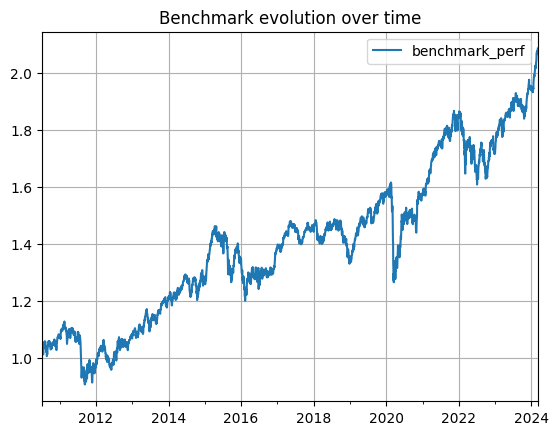

In [2]:
bench_obj = Benchmark(RebalanceFrequencyEnum.MONTH_END) # Create the benchmark with a monthly rebalance frequency


bench_obj.benchmark_perf.plot(grid=True,legend=True,title="Benchmark evolution over time")

bench_obj.benchmark_perf

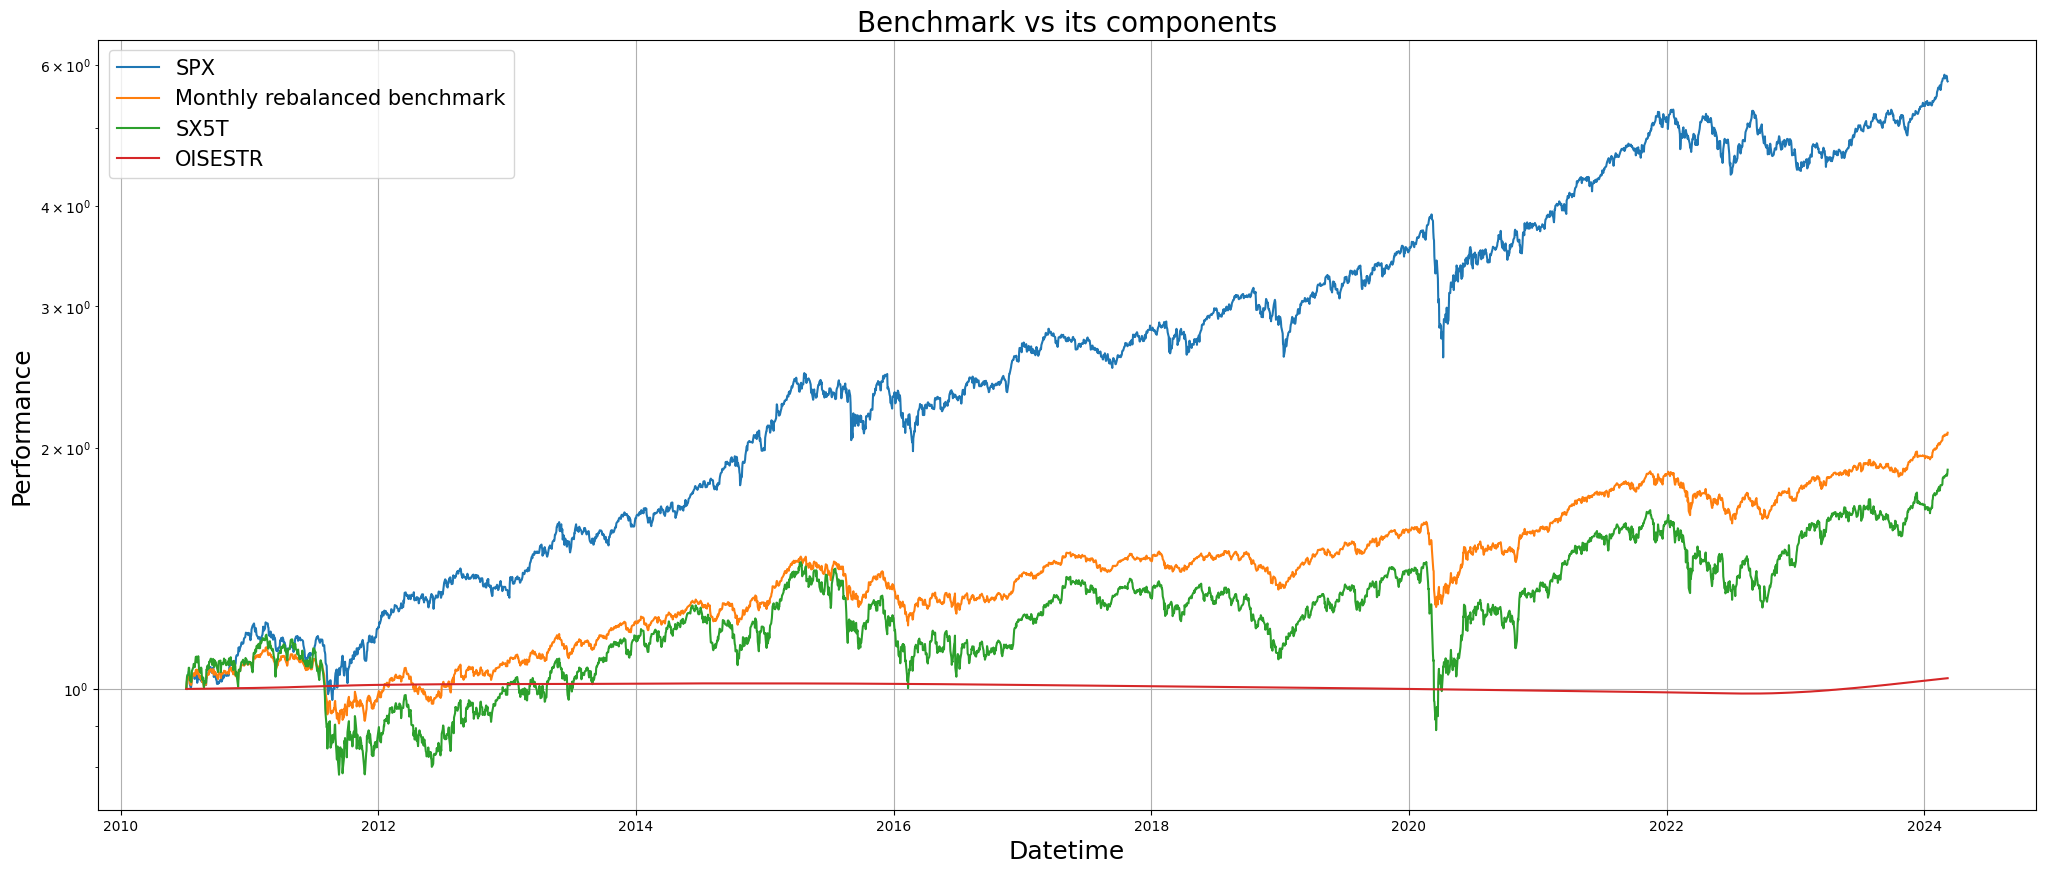

In [3]:
component = bench_obj.get_benchmark_returns_data()
plt.figure(figsize=(25, 10))
plt.plot((component["SPX"] + 1).cumprod(), label="SPX")

plt.plot(bench_obj.benchmark_perf, label="Monthly rebalanced benchmark")
plt.plot((component["SX5T"] + 1).cumprod(), label="SX5T")
plt.plot((component["OISESTR"] + 1).cumprod(), label="OISESTR")
plt.yscale('log')
plt.xlabel("Datetime", fontsize=18)
plt.ylabel("Performance", fontsize=18)
plt.title("Benchmark vs its components", fontsize=20)
plt.grid()
plt.legend(fontsize=15)

## Benchmark weights evolution over time

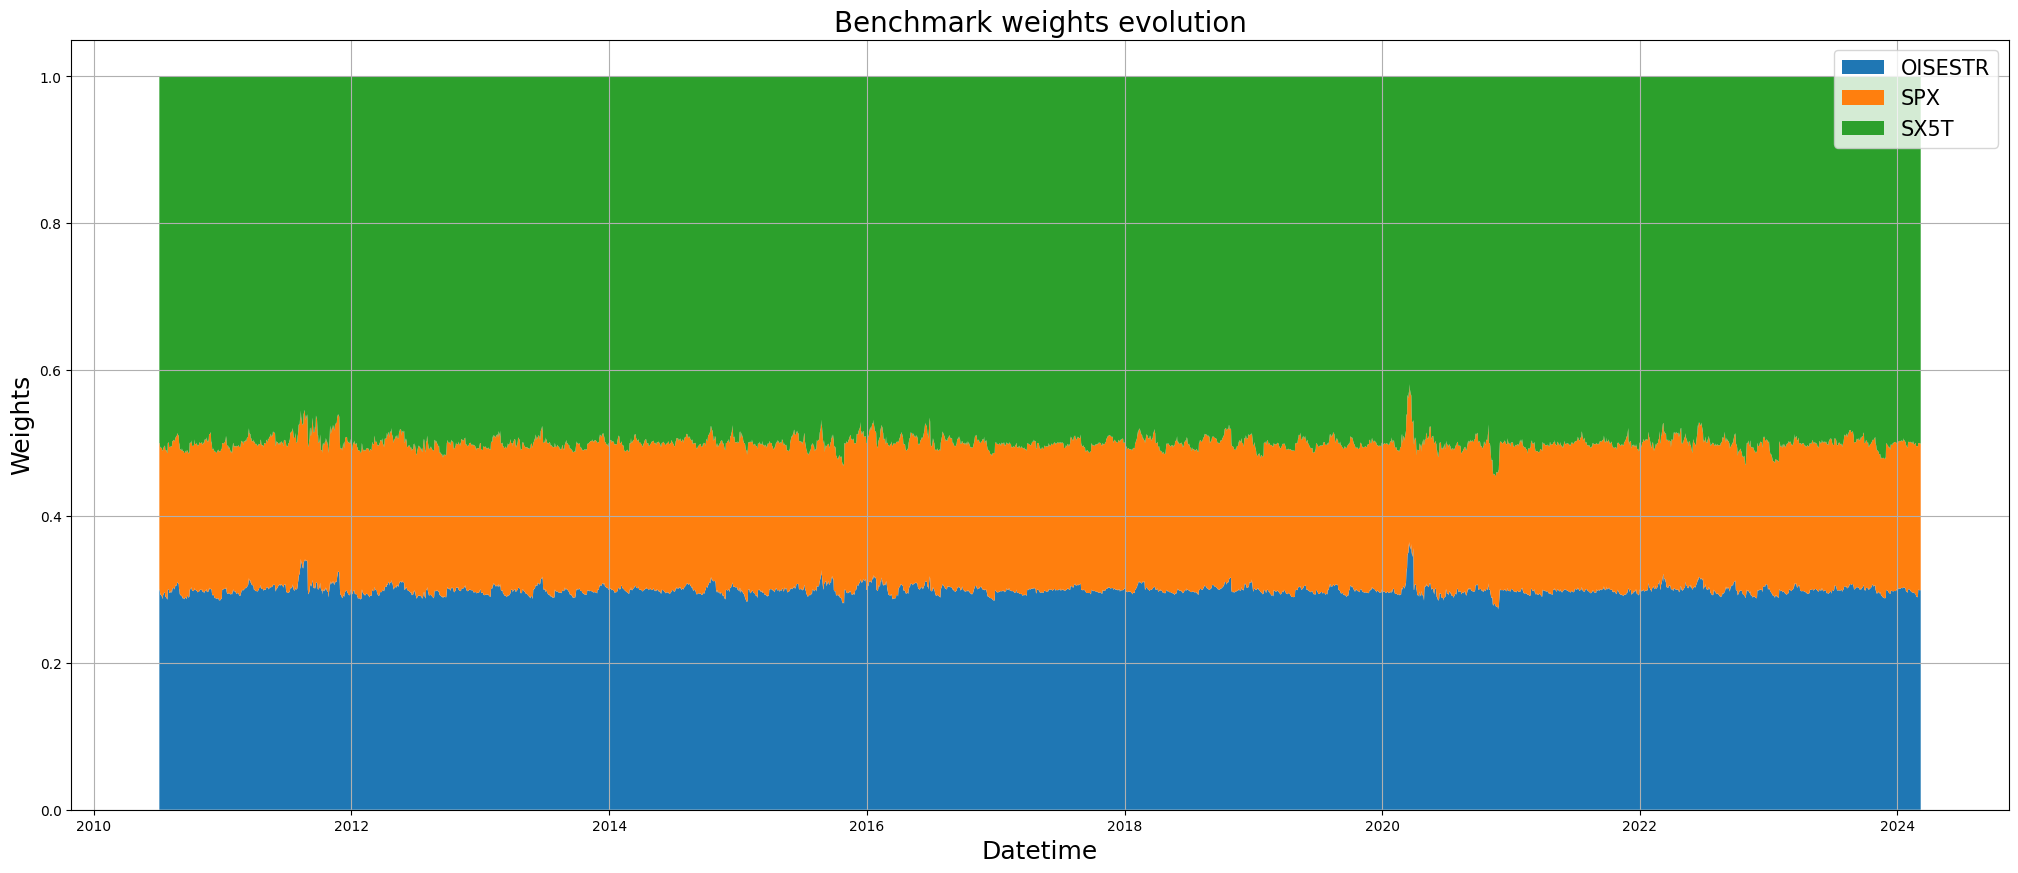

In [4]:
weights_df = bench_obj.benchmark_weights

plt.figure(figsize=(25, 10))
plt.stackplot(
    weights_df.index,
    weights_df.to_numpy().T,
)
plt.xlabel("Datetime", fontsize=18)
plt.ylabel("Weights", fontsize=18)
plt.title("Benchmark weights evolution", fontsize=20)
plt.grid()
plt.legend(weights_df.columns.to_list(),fontsize=15)
plt.show()

# Market Data and Universe

Our universe is composed of 11 assets. 

In [5]:
univ_obj = Universe(market_column="SPTR500N",
                    keep_only_benchmark_universe=False)
universe_df = univ_obj.get_universe_returns()
universe_df

,EUROPE _VALUE_FACTOR,WATER_ESG,STOXX_EUROPE 600_TECHNOLOGY,STOXX_EUROPE 600_HEALTHCARE,EPSILON_TREND,Px fut SX5E,Px fut sp500,Px fut nasdaq,SX5T,SPTR500N,ESTR_ETF
2011-04-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-04-18,-0.019838,-0.008338,-0.015371,-0.005608,-0.023932,-0.023910,-0.013460,-0.008551,-0.024178,-0.003812,0.000045
2011-04-19,0.002565,-0.001201,-0.000905,0.003589,0.011258,0.001801,0.005765,0.009170,0.003744,0.008637,0.000045
2011-04-20,0.018252,0.011425,0.026495,0.017625,0.022580,0.023013,0.015094,0.019039,0.022820,0.000976,0.000048
2011-04-21,0.002988,0.001189,0.010368,-0.002259,0.005438,0.008436,0.002070,0.008705,0.006865,-0.002491,0.000057
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,0.004568,0.005994,0.015707,0.013283,0.003002,0.001430,0.008278,0.014129,0.001428,0.004299,0.000155
2024-03-04,-0.003465,0.003610,0.007408,0.004546,0.005692,0.003469,-0.001506,-0.004158,0.004018,0.002917,0.000155
2024-03-05,0.002646,-0.005968,-0.016467,-0.005092,0.000850,-0.004270,-0.010217,-0.018166,-0.004131,-0.003285,0.000155
2024-03-06,0.003564,0.000316,0.012498,0.001467,0.001088,0.005105,0.005112,0.006358,0.005315,-0.011630,0.000155


# Asset performance in the two regimes

In [12]:
universe_data = universe_df.copy()
 
 
REGIMES = detect_market_regime(
    market_data=universe_data[["SPTR500N"]].to_numpy(),#.pct_change().fillna(0).to_numpy(),
    market_regime_detection_algorithm=RegimeDetectionModels.HIDDEN_MARKOV_MODEL,
    scale_data=True,
    scaler_type="robust",
)
universe_data["REGIMES"] = REGIMES

In [16]:
(universe_data[universe_data['REGIMES']==0].mean()*252).sort_values()

REGIMES                        0.000000
ESTR_ETF                       0.002998
EPSILON_TREND                  0.041172
SX5T                           0.073811
EUROPE _VALUE_FACTOR           0.082541
Px fut SX5E                    0.085406
WATER_ESG                      0.115171
Px fut sp500                   0.123379
STOXX_EUROPE 600_HEALTHCARE    0.139633
STOXX_EUROPE 600_TECHNOLOGY    0.153545
Px fut nasdaq                  0.178092
SPTR500N                       0.249506
dtype: float64

In [15]:
(universe_data[universe_data['REGIMES']==1].mean()*252).sort_values()

SPTR500N                        -0.181119
Px fut SX5E                     -0.001060
ESTR_ETF                        -0.000914
EUROPE _VALUE_FACTOR             0.018881
SX5T                             0.019881
STOXX_EUROPE 600_HEALTHCARE      0.031652
EPSILON_TREND                    0.040064
STOXX_EUROPE 600_TECHNOLOGY      0.089485
Px fut sp500                     0.100192
WATER_ESG                        0.103843
Px fut nasdaq                    0.170753
REGIMES                        252.000000
dtype: float64

# Beta convergence during market regime
This chart shows the evolution of the stock exposure over time using an exponential smoothing function. The smoothing function looks like:
$$\beta_i = \frac{\beta_{final}-\beta_0}{1-e^{-\frac{\lambda}{\beta_{i-1}}}}$$
At each iteration this function uses:

- $\beta_0$ The initial beta at the beginning of the market regime
- $\beta_{i-1}$ The pervious beta calculated by this function
- $\beta_{final}$ The long term value to converge to
- $\lambda$ The smoothing coefficient

The word beta here correspond to the stock exposure and not to the real beta $\frac{cov(r_i,r_m)}{\sigma^2_{r_m}}$.


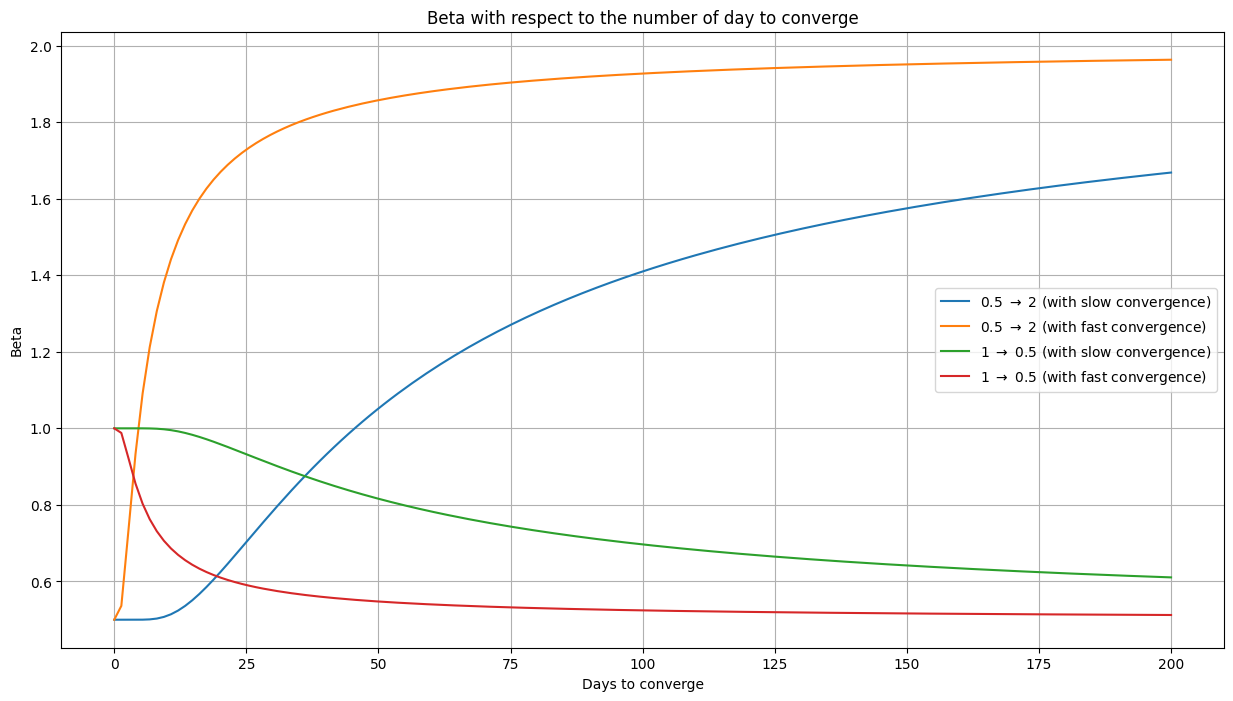

In [6]:

plt.figure(figsize=(15,8))
plt.plot(
    np.linspace(0, 200, 150),
    beta_convergence(np.linspace(0, 200, 150), 0.5, 2, 50),
    label=r"0.5 $\rightarrow$ 2 (with slow convergence)",
)
plt.plot(
    np.linspace(0, 200, 150),
    beta_convergence(np.linspace(0, 200, 150), 0.5, 2, 5),
    label=r"0.5 $\rightarrow$ 2 (with fast convergence)",
)
plt.plot(
    np.linspace(0, 200, 150),
    beta_convergence(np.linspace(0, 200, 150), 1, 0.5, 50),
    label=r"1 $\rightarrow$ 0.5 (with slow convergence)",
)
plt.plot(
    np.linspace(0, 200, 150),
    beta_convergence(np.linspace(0, 200, 150), 1, 0.5, 5),
    label=r"1 $\rightarrow$ 0.5 (with fast convergence)",
)
plt.title("Beta with respect to the number of day to converge")
plt.xlabel("Days to converge")
plt.ylabel("Beta")
plt.grid()
plt.legend()

# Backtest
Then we backtest the solution with a rebalance frequency, a regime detection frequency and a regime detection algorithm. We also have to provide a the bearish stock exposure (`bearish_beta`) and the bullish stock exposure (`bullish_beta`).

The class `Backtester` takes as input an instance of the class `Universe` and a series of returns corresponding to the benchmark.


-------  Returns statistical information  --------
Expected return annualized: 11.36 % vs 5.37 % (benchmark)
Alpha annualized: 2.64 %
CAGR: 9.73 % vs 4.97 % (benchmark)
Expected volatility annualized: 20.52 % vs 10.36 % (benchmark)
Specific volatility (diversifiable) annualized: 11.76 %
Systematic volatility annualized: 16.82 %
Skewness: -0.80 vs -0.52 (benchmark), <0 = left tail, >0 = right tail
Kurtosis: 14.75 vs -0.52 (benchmark) , >3 = fat tails, <3 = thin tails
95%-VaR: -1.91 % vs -1.04 % (benchmark) -> the lower the better
95%-CVaR: -3.21 % vs -1.59 % (benchmark) -> the lower the better

-------  Strategy statistical information  -------
Max drawdown: -44.96 % vs -21.70 % (benchmark)
Kelly criterion: 5.55 % vs 4.83 % (benchmark)
Benchmark sensitivity (beta): 1.62 vs 1 (benchmark)
Determination coefficient R²: 0.67
Tracking error annualized: 13.42 %

---------------  Strategy ratios  ----------------
No risk free rate considered for the following ratios.

Sharpe ratio annualized:

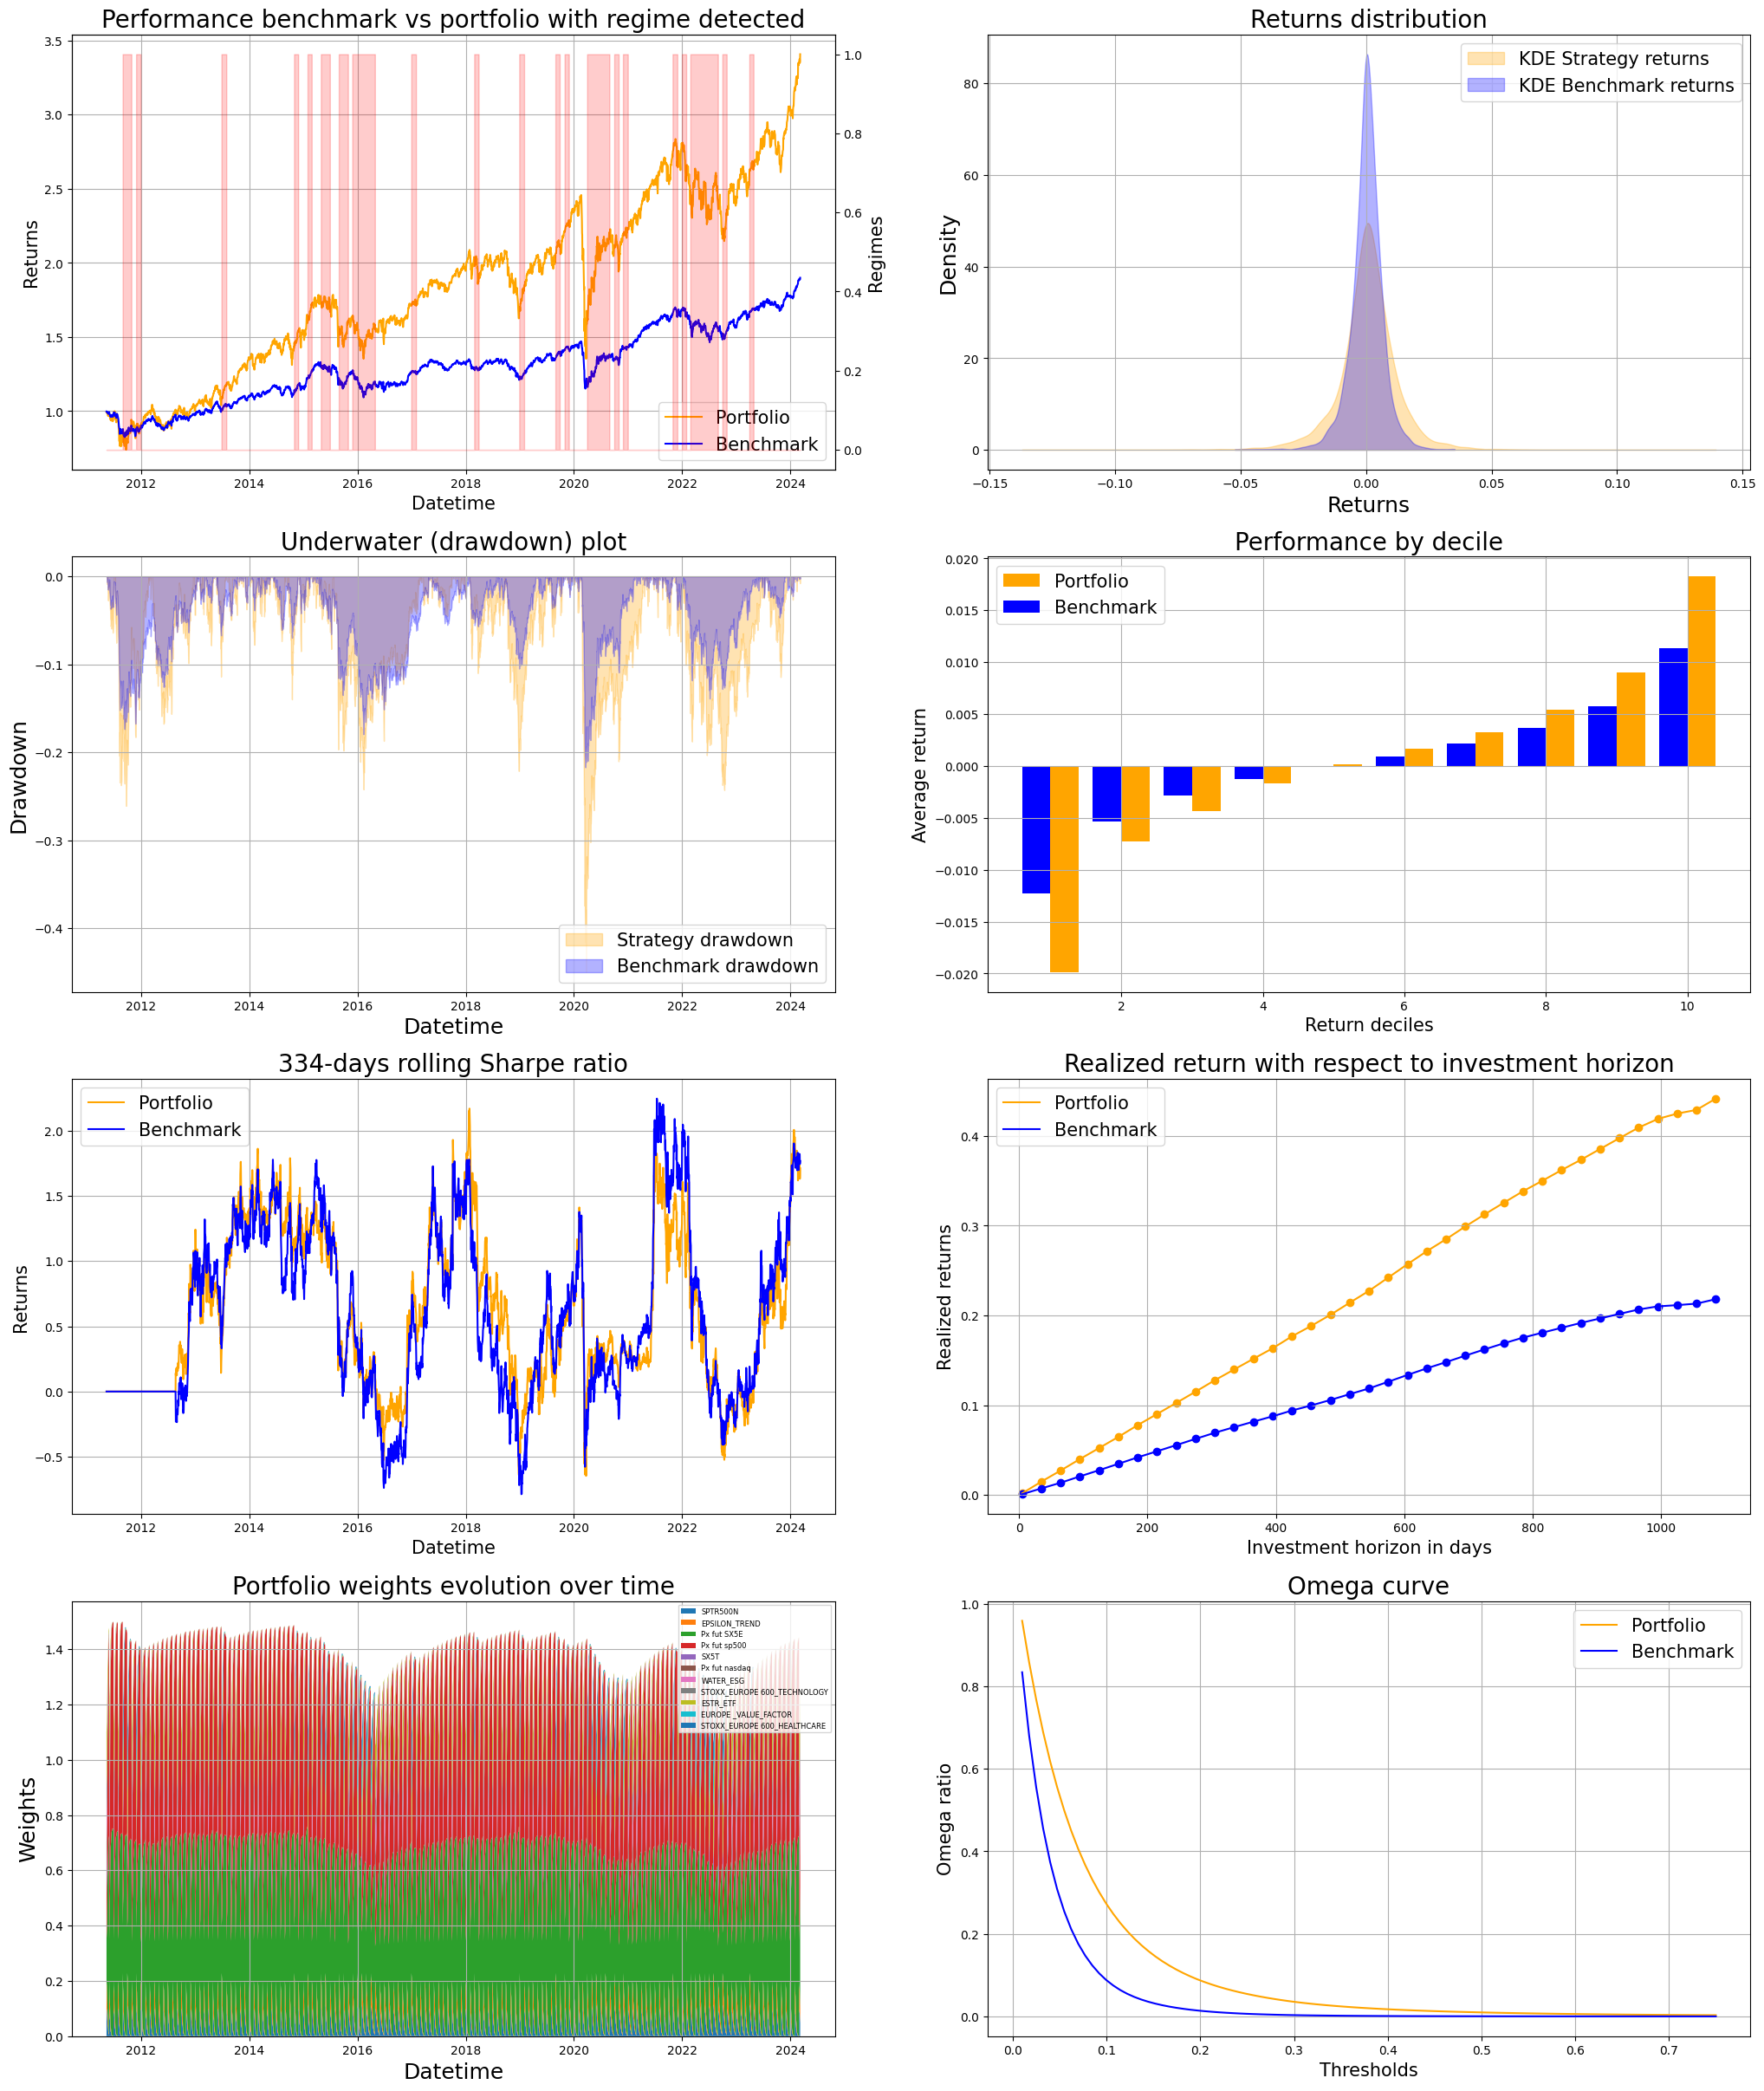

In [9]:
bk_tester = Backtester(
    universe_obj=Universe(market_column="SPTR500N",keep_only_benchmark_universe=False),
    benchmark_returns=bench_obj.benchmark_returns
)

ptf_and_bench, ptf_weights_equal_weight, regimes, metrics_df = bk_tester.run_backtest(
    rebalance_frequency=RebalanceFrequencyEnum.MONTH_END,
    regime_frequency=RebalanceFrequencyEnum.MONTH_END,
    market_regime_model=RegimeDetectionModels.HIDDEN_MARKOV_MODEL,
    bullish_beta=1.5,
    bullish_lambda_convergence=50,
    bearish_beta=1.1,
    bearish_lambda_convergence=50,
    verbose=False,
)

# Analyzing the beta (stock exposure to the SX5T and S&P500 using futures)
In this section we show the evolution of the dynamics beta across time for the different regimes. As we selected a different convergence speed in the two regime it normal to have different exposure convergence speed.


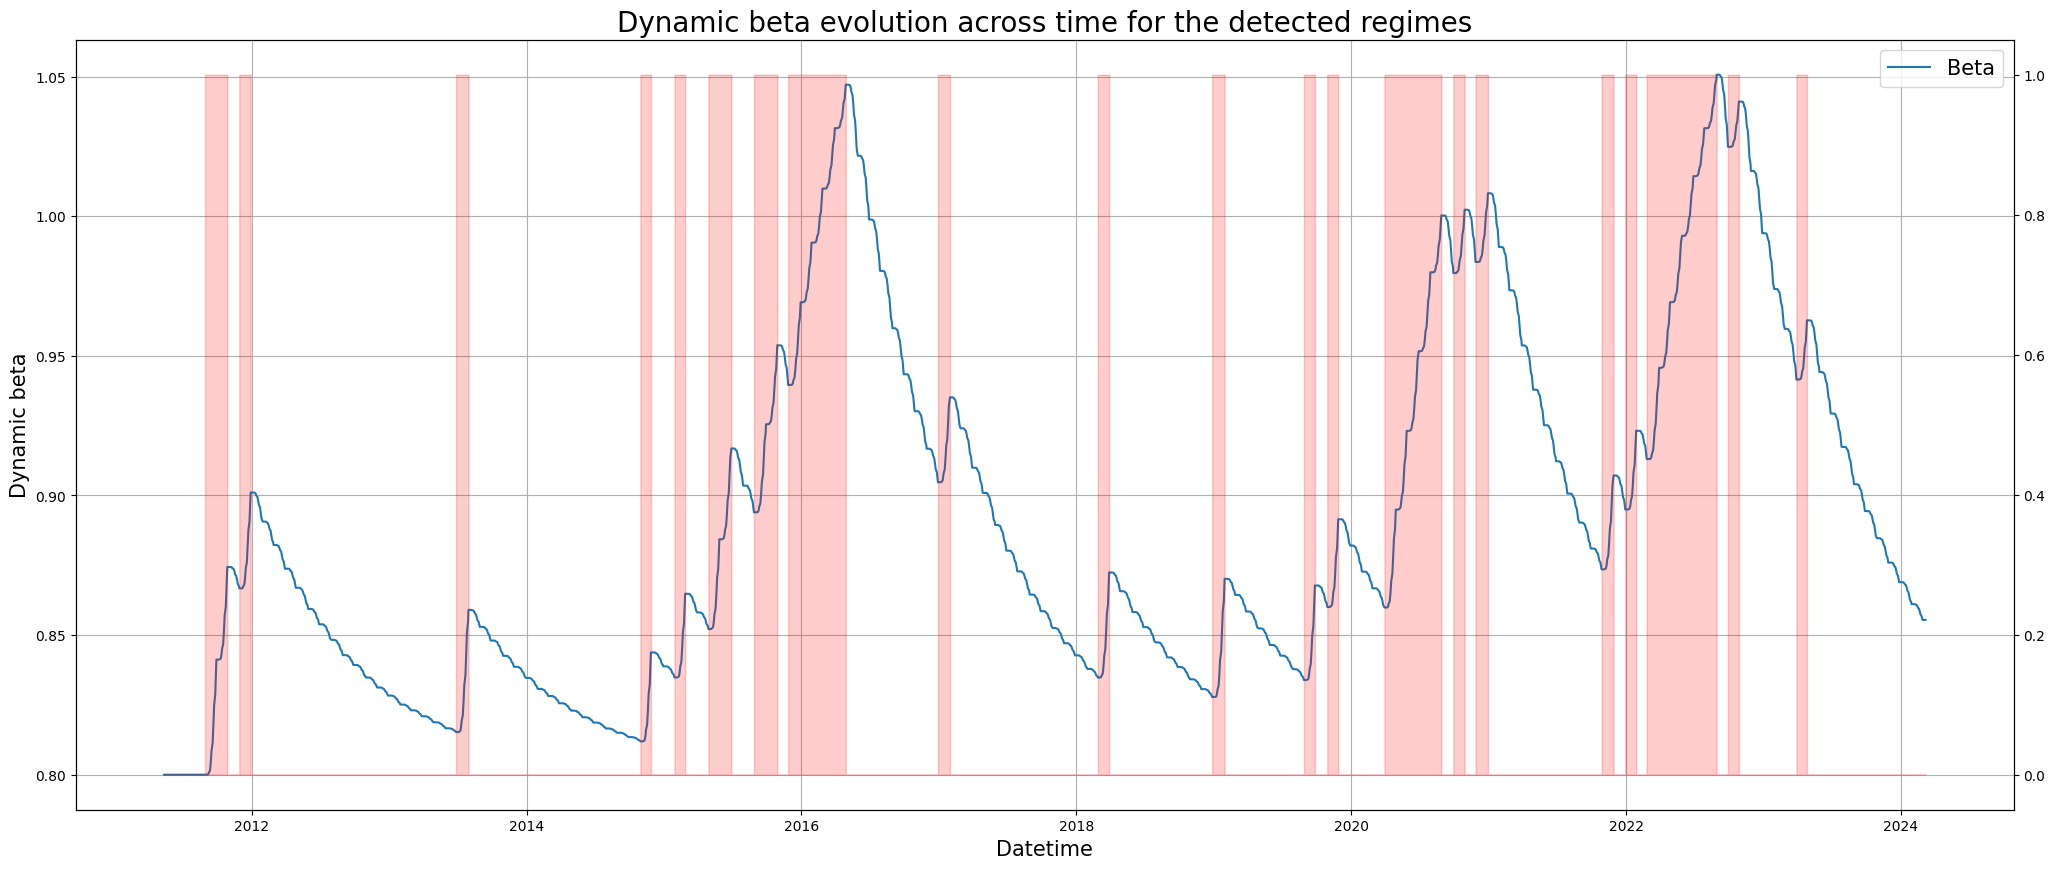

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))


ax.plot(regimes.index, regimes.next_beta, label="Beta")
ax_l = ax.twinx()
ax_l.fill_between(
    regimes.index,
    regimes["Regime"],
    alpha=0.2,
    color="red",
    step="pre",
)
ax_l.set_xlabel("Market regime (0=bull, 1=bear)", fontsize=15)
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Dynamic beta", fontsize=15)
ax.set_title(
    f"Dynamic beta evolution across time for the detected regimes", fontsize=20
)
ax.grid()
ax.legend(fontsize=15)